# Part 1: Read hazards from raster data

/Users/arnaudgoussebaile/miniconda3/envs/climada_env/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 8.0.0. Please consider upgrading.
  warnings.warn(


event_id:  [1]
event_name:  ['1']
date:  [1.]
frequency:  [0.5]
orig:  [ True]
min, max fraction:  0.0 1.0


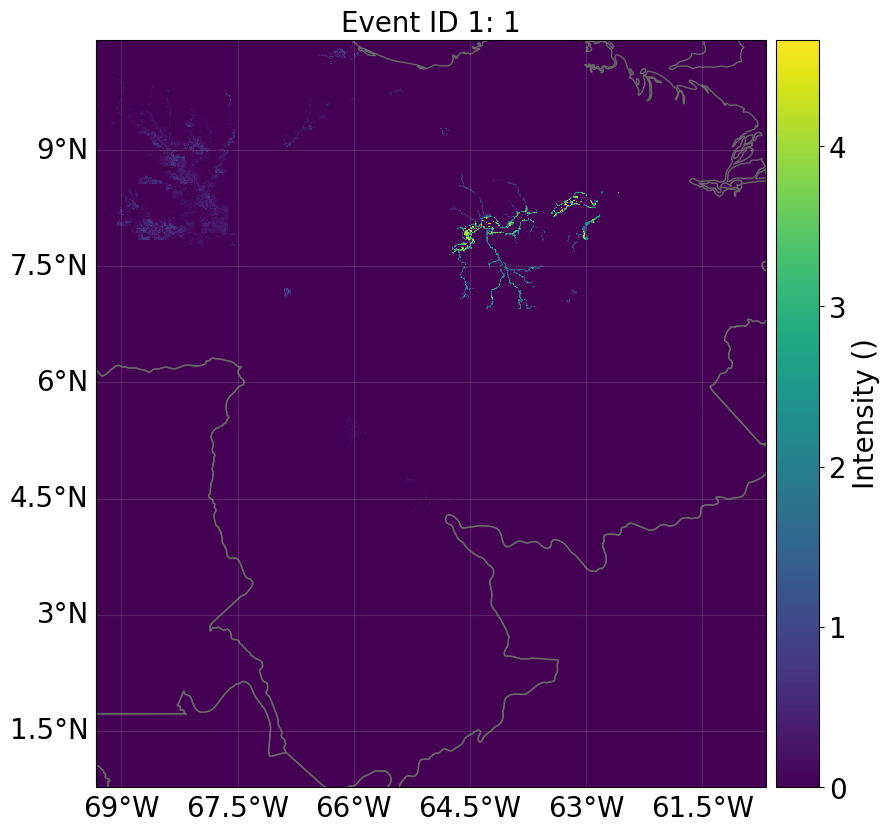

In [1]:
%matplotlib inline
import numpy as np
from climada.hazard import Hazard
from climada.util.constants import HAZ_DEMO_FL
# to hide the warnings
import warnings
warnings.filterwarnings('ignore')

# read intensity from raster file HAZ_DEMO_FL and set frequency for the contained event
haz_ven = Hazard.from_raster([HAZ_DEMO_FL], attrs={'frequency':np.ones(1)/2}, haz_type='FL')
haz_ven.check()

# The masked values of the raster are set to 0
# Sometimes the raster file does not contain all the information, as in this case the mask value -9999
# We mask it manuall and plot it using plot_intensity()
haz_ven.intensity[haz_ven.intensity==-9999] = 0
haz_ven.plot_intensity(1, smooth=False) # if smooth=True (default value) is used, the computation time might increase

# per default the following attributes have been set
print('event_id: ', haz_ven.event_id)
print('event_name: ', haz_ven.event_name)
print('date: ', haz_ven.date)
print('frequency: ', haz_ven.frequency)
print('orig: ', haz_ven.orig)
print('min, max fraction: ', haz_ven.fraction.min(), haz_ven.fraction.max())

1. Read raster data in EPSG 2201 Coordinate Reference System (CRS)

2. Read raster data in its given CRS and transform it to the affine transformation Affine(0.009000000000000341, 0.0, -69.33714959699981, 0.0, -0.009000000000000341, 10.42822096697894), height=500, width=501)

3. Read raster data in window Window(10, 10, 20, 30)

In [2]:
# 1. The CRS can be reprojected using dst_crs option
haz = Hazard.from_raster([HAZ_DEMO_FL], dst_crs='epsg:2201', haz_type='FL')
haz.check()
print('\n Solution 1:')
print('centroids CRS:', haz.centroids.crs)
print('raster info:', haz.centroids.meta)

# 2. Transformations of the coordinates can be set using the transform option and Affine
from rasterio import Affine
haz = Hazard.from_raster([HAZ_DEMO_FL], haz_type='FL',
                         transform=Affine(0.009000000000000341, 0.0, -69.33714959699981, \
                                          0.0, -0.009000000000000341, 10.42822096697894),
                         height=500, width=501)
haz.check()
print('\n Solution 2:')
print('raster info:', haz.centroids.meta)
print('intensity size:', haz.intensity.shape)

# 3. A partial part of the raster can be loaded using the window or geometry
from rasterio.windows import Window
haz = Hazard.from_raster([HAZ_DEMO_FL], haz_type='FL', window=Window(10, 10, 20, 30))
haz.check()
print('\n Solution 3:')
print('raster info:', haz.centroids.meta)
print('intensity size:', haz.intensity.shape)


 Solution 1:
centroids CRS: epsg:2201
raster info: {'driver': 'GSBG', 'dtype': 'float32', 'nodata': 1.701410009187828e+38, 'width': 978, 'height': 1091, 'count': 1, 'crs': 'epsg:2201', 'transform': Affine(1011.5372910988809, 0.0, 1120744.5486664253,
       0.0, -1011.5372910988809, 1189133.7652687666)}

 Solution 2:
raster info: {'driver': 'GSBG', 'dtype': 'float32', 'nodata': 1.701410009187828e+38, 'width': 501, 'height': 500, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.009000000000000341, 0.0, -69.33714959699981,
       0.0, -0.009000000000000341, 10.42822096697894)}
intensity size: (1, 250500)

 Solution 3:
raster info: {'driver': 'GSBG', 'dtype': 'float32', 'nodata': 1.701410009187828e+38, 'width': 20, 'height': 30, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.009000000000000341, 0.0, -69.2471495969998,
       0.0, -0.009000000000000341, 10.338220966978936)}
intensity size: (1, 600)


# Part 2: Read hazards from other data

In [3]:
from climada.hazard import Hazard, Centroids
from climada.util import HAZ_DEMO_H5 # CLIMADA's Python file
# Hazard needs to know the acronym of the hazard type to be constructed!!! Use 'NA' if not known.
haz_tc_fl = Hazard.from_hdf5(HAZ_DEMO_H5)  # Historic tropical cyclones in Florida from 1990 to 2004
haz_tc_fl.check() # Use always the check() method to see if the hazard has been loaded correctly


# Part 3: Define hazards manually

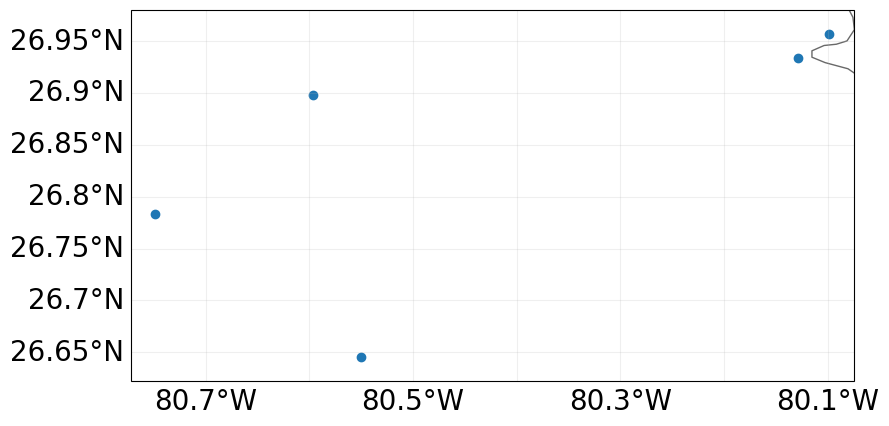

In [7]:
# setting points
import numpy as np
from scipy import sparse

lat = np.array([26.933899, 26.957203, 26.783846, 26.645524, 26.897796])

lon = np.array([-80.128799, -80.098284, -80.748947, -80.550704, -80.596929])

n_cen = lon.size # number of centroids
n_ev = 10 # number of events

intensity = sparse.csr_matrix(np.random.random((n_ev, n_cen)))
fraction = intensity.copy()
fraction.data.fill(1)

haz = Hazard(haz_type='TC',
             intensity=intensity,
             fraction=fraction,
             centroids=Centroids.from_lat_lon(lat, lon),  # default crs used
             units='m',
             event_id=np.arange(n_ev, dtype=int),
             event_name=['ev_12', 'ev_21', 'Maria', 'ev_35',
                         'Irma', 'ev_16', 'ev_15', 'Edgar', 'ev_1', 'ev_9'],
             date=np.array([721166, 734447, 734447, 734447, 721167,
                            721166, 721167, 721200, 721166, 721166]),
             orig=np.zeros(n_ev, bool),
             frequency=np.ones(n_ev)/n_ev,)

haz.check()
haz.centroids.plot();

2024-03-12 10:14:28,723 - climada.hazard.centroids.centr - WARNING - Centroids.from_pix_bounds has been deprecated and will be removed in a future version. Use Centroids.from_pnt_bounds instead.
Check centroids borders: (-72.0, -3.0, -52.0, 22.0)
Check centroids borders: (-72.25, -3.25, -51.75, 22.25)


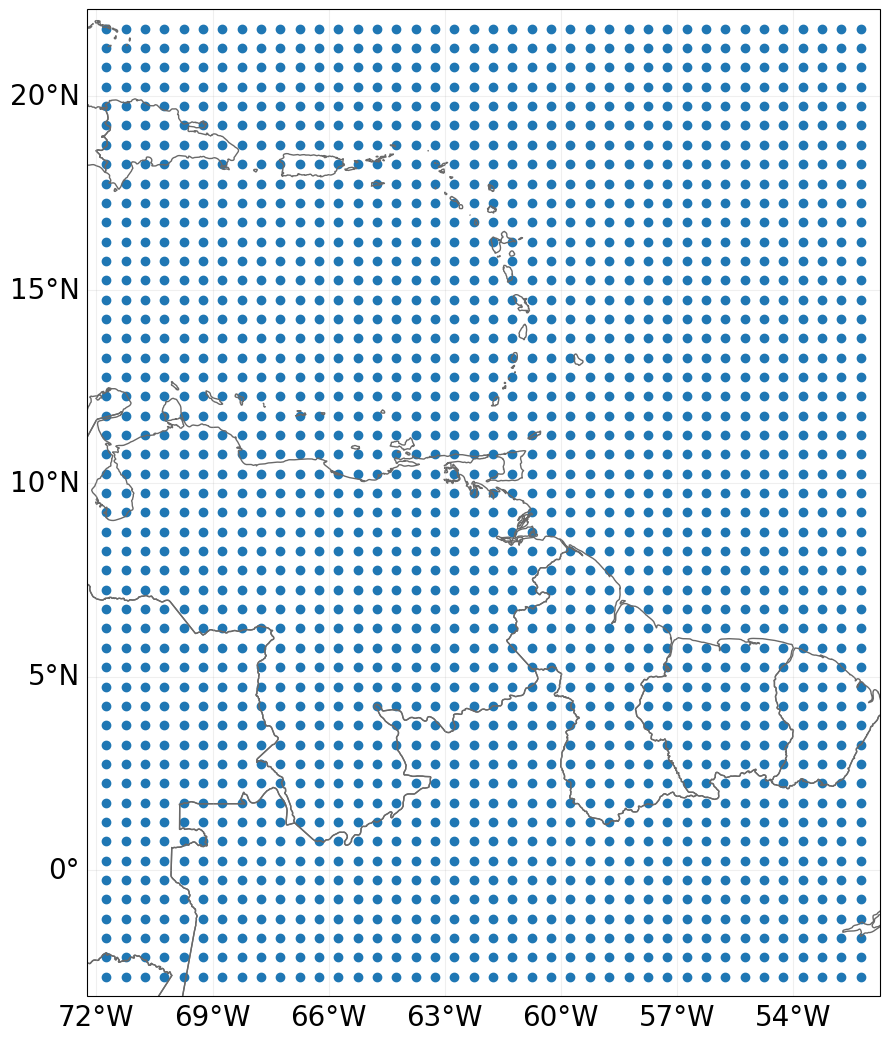

In [8]:
# setting raster
import numpy as np
from scipy import sparse

# raster info:
# border upper left corner (of the pixel, not of the center of the pixel)
xf_lat = 22
xo_lon = -72
# resolution in lat and lon
d_lat = -0.5 # negative because starting in upper corner
d_lon = 0.5 # same step as d_lat
# number of points
n_lat = 50
n_lon = 40

n_ev = 10 # number of events
centroids = Centroids.from_pix_bounds(xf_lat, xo_lon, d_lat, d_lon, n_lat, n_lon) # default crs used
intensity = sparse.csr_matrix(np.random.random((n_ev, centroids.size)))
fraction = intensity.copy()
fraction.data.fill(1)

haz = Hazard('TC',
             centroids=centroids,
             intensity=intensity,
             fraction=fraction,
             units='m',
             event_id=np.arange(n_ev, dtype=int),
             event_name=['ev_12', 'ev_21', 'Maria', 'ev_35',
                         'Irma', 'ev_16', 'ev_15', 'Edgar', 'ev_1', 'ev_9'],
             date=np.array([721166, 734447, 734447, 734447, 721167,
                            721166, 721167, 721200, 721166, 721166]),
             orig=np.zeros(n_ev, bool),
             frequency=np.ones(n_ev)/n_ev,)

haz.check()
print('Check centroids borders:', haz.centroids.total_bounds)
haz.centroids.plot()

# using from_pnt_bounds, the bounds refer to the bounds of the center of the pixel
left, bottom, right, top = xo_lon, -3.0, -52.0, xf_lat
haz.centroids = Centroids.from_pnt_bounds((left, bottom, right, top), 0.5) # default crs used
print('Check centroids borders:', haz.centroids.total_bounds)

# Part 4: Analyse Hazards

Using the previous hazard haz_tc_fl answer these questions:

1. How many synthetic events are contained?

2. Generate a hazard with historical hurricanes ocurring between 1995 and 2001.

3. How many historical hurricanes occured in 1999? Which was the year with most hurricanes between 1995 and 2001?

4. What is the number of centroids with distance to coast smaller than 1km?

In [10]:
# 1.How many synthetic events are contained?
print('Number of total events:', haz_tc_fl.size)
print('Number of synthetic events:', np.logical_not(haz_tc_fl.orig).astype(int).sum())

# 2. Generate a hazard with historical hurricanes ocurring between 1995 and 2001.
hist_tc = haz_tc_fl.select(date=('1995-01-01', '2001-12-31'), orig=True)
print('Number of historical events between 1995 and 2001:', hist_tc.size)

# 3. How many historical hurricanes occured in 1999? Which was the year with most hurricanes between 1995 and 2001?
ev_per_year = hist_tc.calc_year_set() # events ids per year
print('Number of events in 1999:', ev_per_year[1999].size)
max_year = 1995
max_ev = ev_per_year[1995].size
for year, ev in ev_per_year.items():
    if ev.size > max_ev:
        max_year = year
print('Year with most hurricanes between 1995 and 2001:', max_year)

# 4. What is the number of centroids with distance to coast smaller than 1km?
hist_tc.centroids.set_dist_coast()
num_cen_coast = np.argwhere(hist_tc.centroids.dist_coast < 1000).size
print('Number of centroids close to coast: ', num_cen_coast)

Number of total events: 216
Number of synthetic events: 0
Number of historical events between 1995 and 2001: 109
Number of events in 1999: 16
Year with most hurricanes between 1995 and 2001: 1995
Number of centroids close to coast:  41


# Part 5: Visualize Hazards

2024-03-12 10:51:27,752 - climada.hazard.base - WARNING - Exceedance intenstiy values below 0 are set to 0.                    Reason: no negative intensity values were found in hazard.


<Axes: title={'center': 'Centroid 49: (21.0, -75.0)'}, xlabel='Event number', ylabel='Intensity (m/s)'>

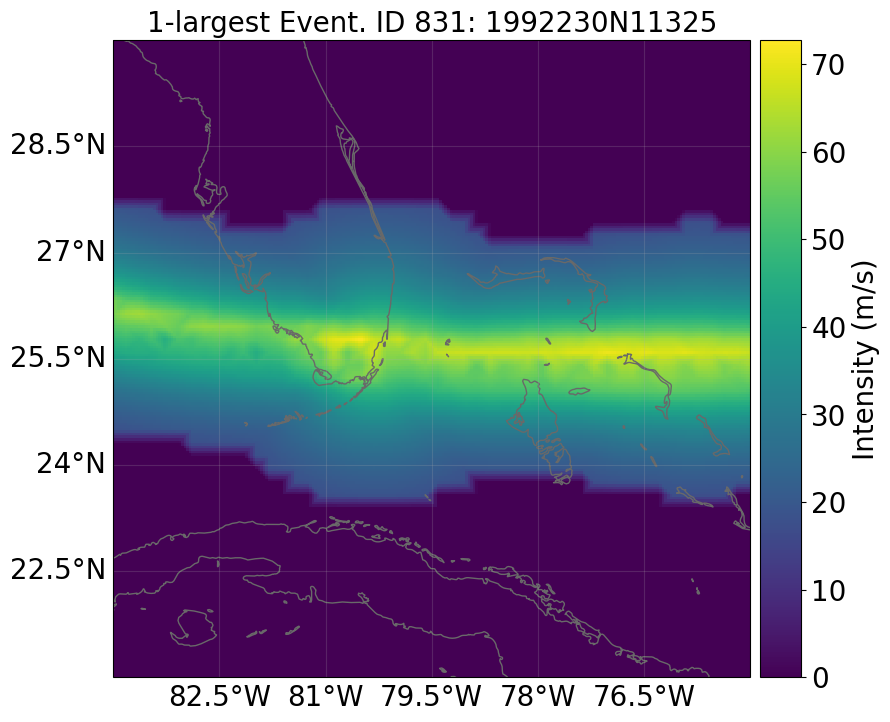

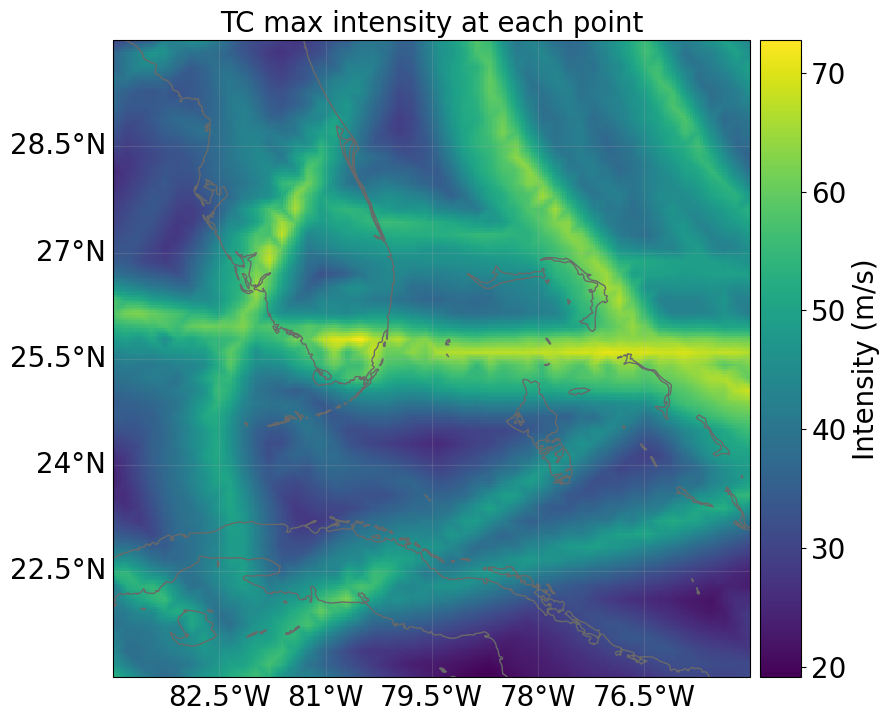

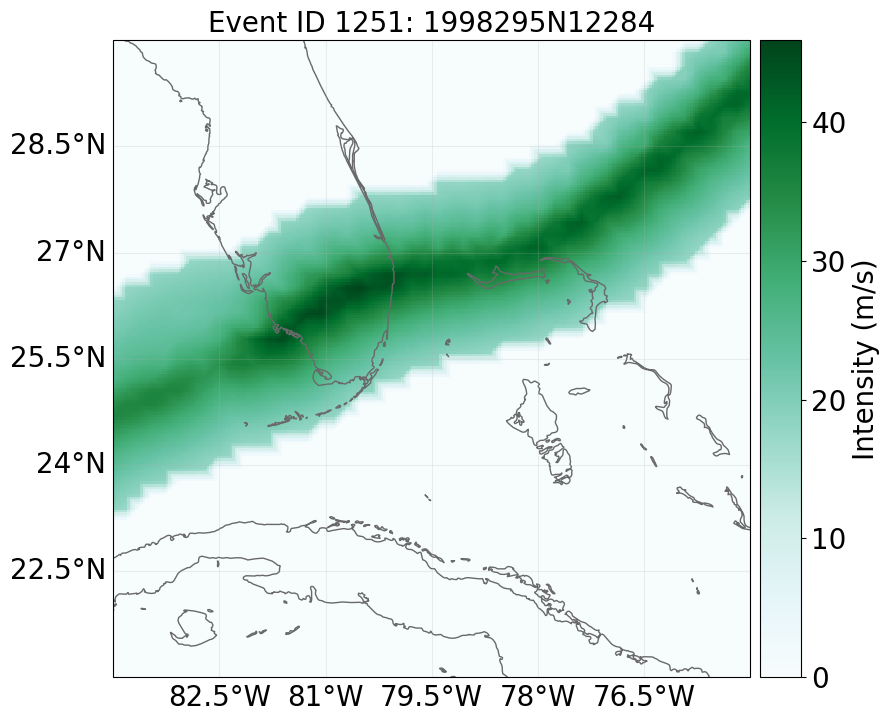

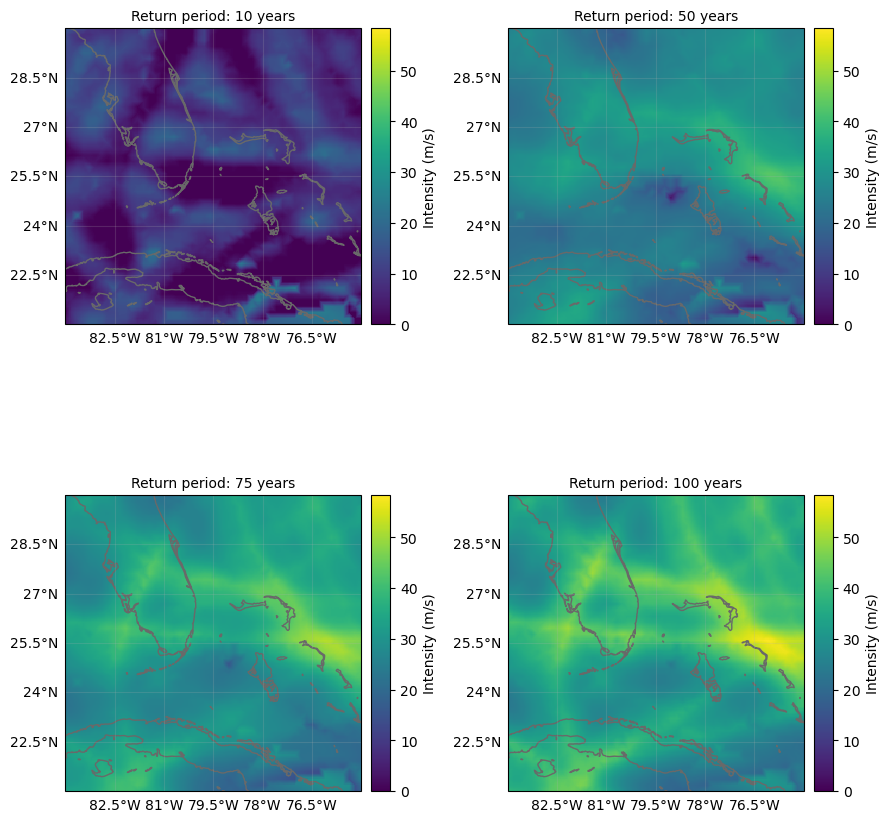

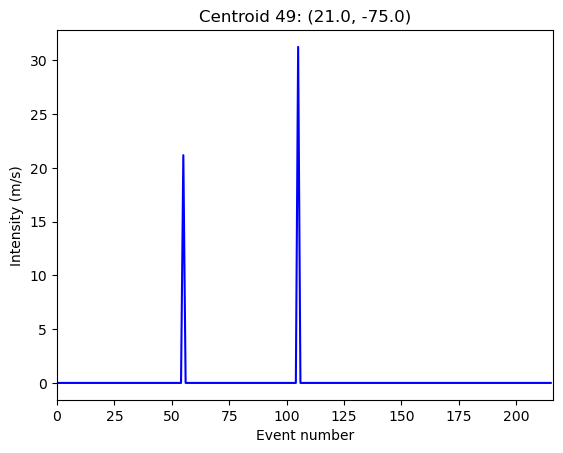

In [15]:
# 1. intensities of the largest event (defined as greater sum of intensities):
# all events:
haz_tc_fl.plot_intensity(event=-1) # largest historical event: 1992230N11325 hurricane ANDREW

# 2. maximum intensities at each centroid:
haz_tc_fl.plot_intensity(event=0)

# 3. intensities of hurricane 1998295N12284:
haz_tc_fl.plot_intensity(event='1998295N12284', cmap='BuGn') # setting color map

# 4. tropical cyclone intensities maps for the return periods [10, 50, 75, 100]
_, res = haz_tc_fl.plot_rp_intensity([10, 50, 75, 100])

# 5. intensities of all the events in centroid with id 50
haz_tc_fl.plot_intensity(centr=49)

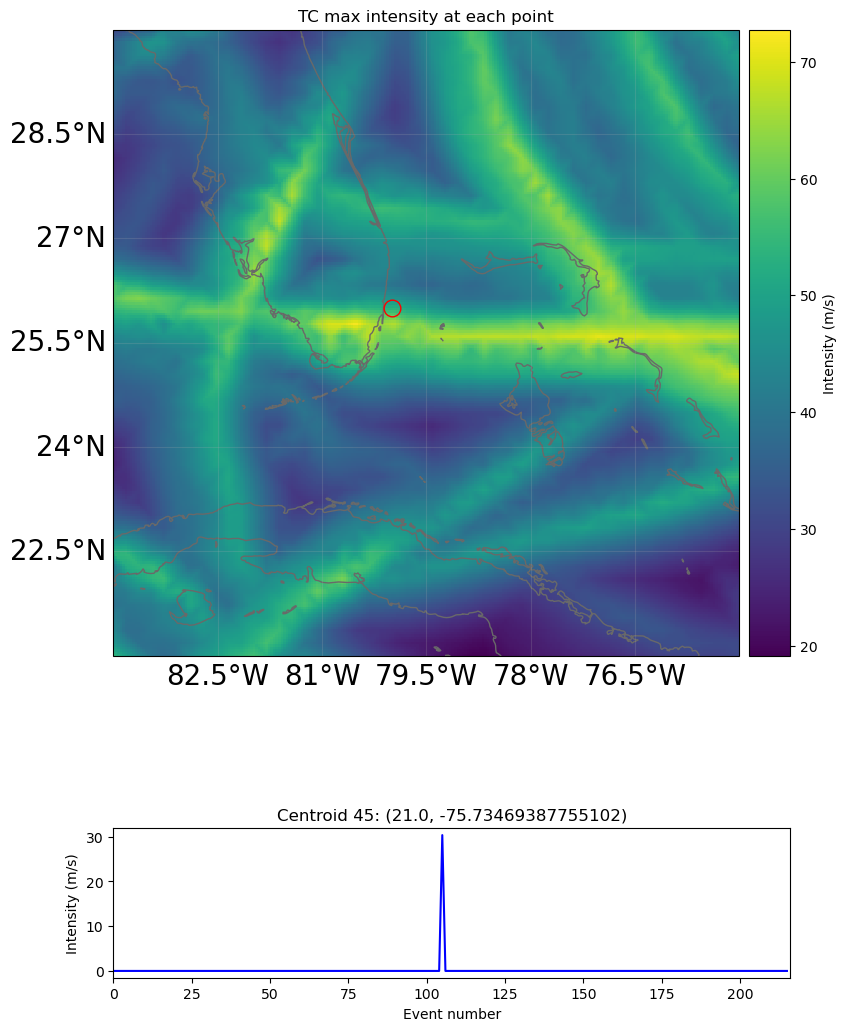

In [20]:
# 7. one figure with two plots: maximum intensities and selected centroid with all intensities:
from climada.util.plot import make_map
import matplotlib.pyplot as plt
plt.ioff()
fig, ax1, fontsize = make_map(1)  # map
ax2 = fig.add_subplot(2, 1, 2) # add regular axes
haz_tc_fl.plot_intensity(axis=ax1, event=0) # plot original resolution
ax1.plot(-80, 26, 'or', mfc='none', markersize=12)
haz_tc_fl.plot_intensity(axis=ax2, centr=45)
fig.subplots_adjust(hspace=6.5)
fig

# Part 6: Write (=save) hazards

In [21]:
haz_tc_fl.write_hdf5('results/haz_tc_fl.h5')

haz = Hazard.from_hdf5('results/haz_tc_fl.h5')
haz.check()

In [22]:
haz_ven.write_raster('results/haz_ven.tif') # each event is a band of the tif file